# DCGAN

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train - 127.5) / 127.5
print(x_train.shape, x_train.min(), x_train.max())


4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) -1.0 1.0


In [8]:
def make_discriminator():
    dx = tf.keras.Input(shape=[28, 28, 1])
    dh = tf.keras.layers.Conv2D(64, 5, 2, padding="same")(dx)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Conv2D(128, 5, 2, padding="same")(dh)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Flatten()(dh)
    dy = tf.keras.layers.Dense(1, activation='sigmoid')(dh)
    return tf.keras.Model(dx, dy)

def make_generator():
    gx = tf.keras.Input(shape=[100])
    gh = tf.keras.layers.Dense(7 * 7 * 128)(gx)
    gh = tf.keras.layers.Reshape([7, 7, 128])(gh)
    gh = tf.keras.layers.Conv2DTranspose(128, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gh = tf.keras.layers.Conv2DTranspose(64, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gy = tf.keras.layers.Conv2DTranspose(1, 7, padding="same", activation="tanh")(gh)
    return tf.keras.Model(gx, gy)


In [3]:
class GAN(tf.keras.Model):
    def __init__(self, g, d):
        super(GAN, self).__init__()
        self.compile()

        self.generator = g
        self.discriminator = d

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        self.d_loss_metrics = tf.keras.metrics.Mean()
        self.d_acc_metrics = tf.keras.metrics.BinaryAccuracy()
        self.g_loss_metrics = tf.keras.metrics.Mean()
        self.g_acc_metrics = tf.keras.metrics.BinaryAccuracy()

    def disc_loss(self, y_real, y_fake):
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_real), y_real)
        fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(y_fake), y_fake)
        return real_loss + fake_loss
    
    def gen_loss(self, y_fake):
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_fake), y_fake)
        return g_loss

    def update_metrics(self, y_real, y_fake, g_loss, d_loss):
        self.d_loss_metrics.update_state(d_loss)
        self.d_acc_metrics.update_state(tf.ones_like(y_real), y_real)
        self.d_acc_metrics.update_state(tf.zeros_like(y_fake), y_fake)
        self.g_loss_metrics.update_state(g_loss)
        self.g_acc_metrics.update_state(tf.ones_like(y_fake), y_fake)

    def train_step(self, real):
        noise = tf.random.normal([tf.shape(real)[0], 100])
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake = self.generator(noise, training=True)
            y_real = self.discriminator(real, training=True)
            y_fake = self.discriminator(fake, training=True)

            g_loss = self.gen_loss(y_fake)
            d_loss = self.disc_loss(y_real, y_fake)

            g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)    
            d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

        self.update_metrics(y_real, y_fake, g_loss, d_loss)
        return {
            "d_loss": self.d_loss_metrics.result(),
            "d_acc": self.d_acc_metrics.result(),
            "g_loss": self.g_loss_metrics.result(),
            "g_acc": self.g_acc_metrics.result(),
        }

In [4]:
import matplotlib.pyplot as plt
import numpy as np

class Monitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_rnd = np.random.randn(5 * 100).reshape(5, 100)
        generated = self.model.generator(x_rnd)
        for i in range(5):
            plt.subplot(1, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated[i].numpy().reshape(28, 28), cmap='gray_r')
        plt.show()

In [9]:
discriminator = make_discriminator()
generator = make_generator()
gen = GAN(generator, discriminator)

In [ ]:
gen.fit(x_train.reshape(-1, 28, 28, 1), epochs=100, batch_size=128, callbacks=[Monitor()])

(25, 100)


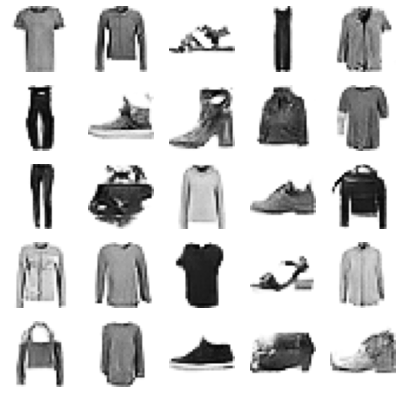

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x_test = np.random.randn(25 * 100).reshape(25, 100)
print(x_test.shape)
plt.figure(figsize=(7, 7))
generated = generator.predict(x_test)
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(generated[i].reshape(28, 28), cmap="gray_r")
plt.show()


In [ ]:
vectors = []
for j in range(len(x_test) - 1):
    for i in range(11):
        vectors.append((1 - 0.1 * i) * x_test[j] + (0.1 * i) * x_test[j + 1])

print(np.array(vectors).shape)

generated = generator.predict(np.array(vectors))
for j in range(len(x_test) - 1):
    plt.figure(figsize=(10, 10))
    for i in range(11):
        plt.subplot(1, 11, 1 + i)
        plt.axis('off')
        plt.imshow(generated[10 * j + i].reshape(28, 28), cmap="gray_r")
    plt.show()

# Conditional GAN

In [33]:
def make_discriminator():
    dx1 = tf.keras.Input(shape=[28, 28, 1])
    dh1 = tf.keras.layers.Flatten()(dx1)

    dx2 = tf.keras.Input(shape=[1])
    dh2 = tf.keras.layers.Embedding(10, 28 * 28)(dx2)
    dh2 = tf.keras.layers.Flatten()(dh2)

    dh = tf.keras.layers.Add()([dh1, dh2])
    dh = tf.keras.layers.Reshape([28, 28, 1])(dh)
    dh = tf.keras.layers.Conv2D(64, 5, 2, padding="same")(dh)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Conv2D(128, 5, 2, padding="same")(dh)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Flatten()(dh)
    dy = tf.keras.layers.Dense(1, activation='sigmoid')(dh)
    return tf.keras.Model([dx1, dx2], dy)

def make_generator():
    gx1 = tf.keras.Input(shape=[100])
    gx2 = tf.keras.Input(shape=[1])

    gh2 = tf.keras.layers.Embedding(10, 100)(gx2)
    gh2 = tf.keras.layers.Flatten()(gh2)
    gh = tf.keras.layers.Add()([gx1, gh2])
    gh = tf.keras.layers.Dense(7 * 7 * 128)(gh)
    gh = tf.keras.layers.Reshape([7, 7, 128])(gh)
    gh = tf.keras.layers.Conv2DTranspose(128, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gh = tf.keras.layers.Conv2DTranspose(64, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gy = tf.keras.layers.Conv2DTranspose(1, 7, padding="same", activation="tanh")(gh)
    return tf.keras.Model([gx1, gx2], gy)


In [36]:
model = make_discriminator()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 784)       7840        ['input_16[0][0]']               
                                                                                                  
 flatten_9 (Flatten)            (None, 784)          0           ['input_15[0][0]']               
                                                                                            

In [43]:
class CGAN(tf.keras.Model):
    def __init__(self, g, d):
        super(CGAN, self).__init__()
        self.compile()

        self.generator = g
        self.discriminator = d

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        self.d_loss_metrics = tf.keras.metrics.Mean()
        self.d_acc_metrics = tf.keras.metrics.BinaryAccuracy()
        self.g_loss_metrics = tf.keras.metrics.Mean()
        self.g_acc_metrics = tf.keras.metrics.BinaryAccuracy()

    def disc_loss(self, y_real, y_fake):
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_real), y_real)
        fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(y_fake), y_fake)
        return real_loss + fake_loss
    
    def gen_loss(self, y_fake):
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_fake), y_fake)
        return g_loss

    def update_metrics(self, y_real, y_fake, g_loss, d_loss):
        self.d_loss_metrics.update_state(d_loss)
        self.d_acc_metrics.update_state(tf.ones_like(y_real), y_real)
        self.d_acc_metrics.update_state(tf.zeros_like(y_fake), y_fake)
        self.g_loss_metrics.update_state(g_loss)
        self.g_acc_metrics.update_state(tf.ones_like(y_fake), y_fake)

    def train_step(self, datasets):
        real, label = datasets[0]
        noise = tf.random.normal([tf.shape(real)[0], 100])
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake = self.generator([noise, label], training=True)
            y_real = self.discriminator([real, label], training=True)
            y_fake = self.discriminator([fake, label], training=True)

            g_loss = self.gen_loss(y_fake)
            d_loss = self.disc_loss(y_real, y_fake)

            g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)    
            d_grad = d_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

        self.update_metrics(y_real, y_fake, g_loss, d_loss)
        return {
            "d_loss": self.d_loss_metrics.result(),
            "d_acc": self.d_acc_metrics.result(),
            "g_loss": self.g_loss_metrics.result(),
            "g_acc": self.g_acc_metrics.result(),
        }

In [57]:
import matplotlib.pyplot as plt
import numpy as np

class Monitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_rnd = np.random.randn(5 * 100).reshape(5, 100)
        labels = np.array([np.random.randint(0, 9) for i in range(5)])
        generated = self.model.generator([x_rnd, labels])
        for i in range(5):
            plt.subplot(1, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated[i].numpy().reshape(28, 28), cmap='gray_r')
        plt.show()
        print(labels)

In [53]:
discriminator = make_discriminator()
generator = make_generator()
gen = CGAN(generator, discriminator)

Epoch 1/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3276 - d_acc: 0.5997 - g_loss: 0.7599 - g_acc: 0.3809

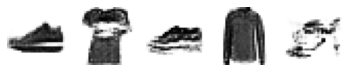

[7 0 7 4 5]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3276 - d_acc: 0.5997 - g_loss: 0.7599 - g_acc: 0.3810
Epoch 2/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3285 - d_acc: 0.5979 - g_loss: 0.7661 - g_acc: 0.3813

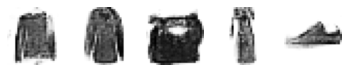

[6 6 8 3 7]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3285 - d_acc: 0.5979 - g_loss: 0.7661 - g_acc: 0.3813
Epoch 3/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3282 - d_acc: 0.5999 - g_loss: 0.7662 - g_acc: 0.3749

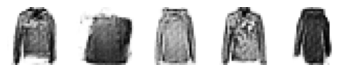

[6 8 2 6 4]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3282 - d_acc: 0.5999 - g_loss: 0.7662 - g_acc: 0.3750
Epoch 4/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3389 - d_acc: 0.5906 - g_loss: 0.7471 - g_acc: 0.3896

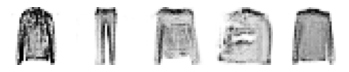

[4 1 2 4 4]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3389 - d_acc: 0.5906 - g_loss: 0.7472 - g_acc: 0.3896
Epoch 5/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3160 - d_acc: 0.6073 - g_loss: 0.7834 - g_acc: 0.3696

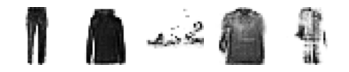

[1 4 5 8 3]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3160 - d_acc: 0.6073 - g_loss: 0.7833 - g_acc: 0.3696
Epoch 6/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3403 - d_acc: 0.5857 - g_loss: 0.7454 - g_acc: 0.3971

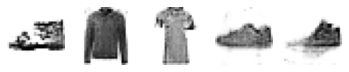

[5 4 0 7 7]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3403 - d_acc: 0.5857 - g_loss: 0.7454 - g_acc: 0.3971
Epoch 7/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3321 - d_acc: 0.5936 - g_loss: 0.7675 - g_acc: 0.3863

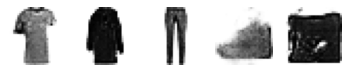

[0 4 1 7 8]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3321 - d_acc: 0.5936 - g_loss: 0.7675 - g_acc: 0.3863
Epoch 8/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3385 - d_acc: 0.5896 - g_loss: 0.7452 - g_acc: 0.3908

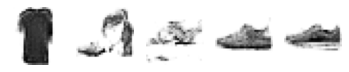

[3 5 5 5 7]
469/469 [==============================] - 20s 43ms/step - d_loss: 1.3385 - d_acc: 0.5896 - g_loss: 0.7452 - g_acc: 0.3908
Epoch 9/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3356 - d_acc: 0.5947 - g_loss: 0.7548 - g_acc: 0.3869

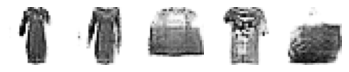

[3 3 8 0 8]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3356 - d_acc: 0.5947 - g_loss: 0.7547 - g_acc: 0.3869
Epoch 10/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3328 - d_acc: 0.5932 - g_loss: 0.7667 - g_acc: 0.3891

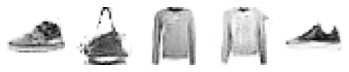

[7 8 2 6 7]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3328 - d_acc: 0.5932 - g_loss: 0.7666 - g_acc: 0.3891
Epoch 11/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3385 - d_acc: 0.5920 - g_loss: 0.7442 - g_acc: 0.3846

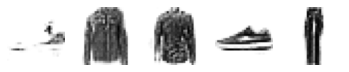

[5 6 6 7 1]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3385 - d_acc: 0.5920 - g_loss: 0.7442 - g_acc: 0.3846
Epoch 12/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3268 - d_acc: 0.5960 - g_loss: 0.7713 - g_acc: 0.3805

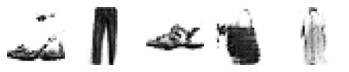

[5 1 5 8 6]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3268 - d_acc: 0.5960 - g_loss: 0.7713 - g_acc: 0.3805
Epoch 13/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3390 - d_acc: 0.5886 - g_loss: 0.7470 - g_acc: 0.3900

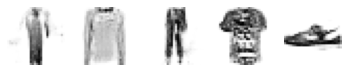

[1 2 1 0 5]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3390 - d_acc: 0.5886 - g_loss: 0.7470 - g_acc: 0.3900
Epoch 14/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3297 - d_acc: 0.5989 - g_loss: 0.7702 - g_acc: 0.3794

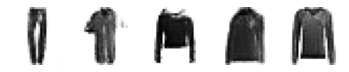

[1 0 2 2 2]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3297 - d_acc: 0.5989 - g_loss: 0.7702 - g_acc: 0.3794
Epoch 15/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3351 - d_acc: 0.5914 - g_loss: 0.7500 - g_acc: 0.3905

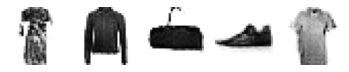

[3 2 8 7 6]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3351 - d_acc: 0.5914 - g_loss: 0.7500 - g_acc: 0.3905
Epoch 16/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3281 - d_acc: 0.5979 - g_loss: 0.7704 - g_acc: 0.3739

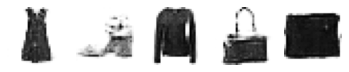

[3 5 2 8 8]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3281 - d_acc: 0.5979 - g_loss: 0.7704 - g_acc: 0.3739
Epoch 17/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3382 - d_acc: 0.5882 - g_loss: 0.7476 - g_acc: 0.3882

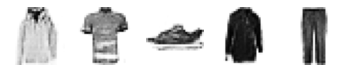

[4 0 7 4 1]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3382 - d_acc: 0.5882 - g_loss: 0.7476 - g_acc: 0.3882
Epoch 18/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3350 - d_acc: 0.5923 - g_loss: 0.7597 - g_acc: 0.3856

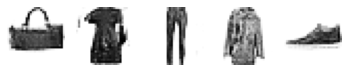

[8 3 1 4 7]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3350 - d_acc: 0.5923 - g_loss: 0.7597 - g_acc: 0.3857
Epoch 19/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3298 - d_acc: 0.5950 - g_loss: 0.7656 - g_acc: 0.3837

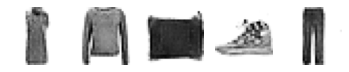

[3 2 8 7 1]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3298 - d_acc: 0.5950 - g_loss: 0.7656 - g_acc: 0.3837
Epoch 20/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3334 - d_acc: 0.5948 - g_loss: 0.7495 - g_acc: 0.3834

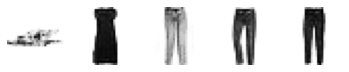

[5 3 1 1 1]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3334 - d_acc: 0.5947 - g_loss: 0.7495 - g_acc: 0.3834
Epoch 21/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3399 - d_acc: 0.5866 - g_loss: 0.7530 - g_acc: 0.3940

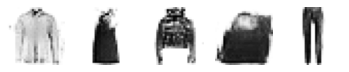

[6 0 4 8 1]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3399 - d_acc: 0.5867 - g_loss: 0.7530 - g_acc: 0.3940
Epoch 22/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3342 - d_acc: 0.5909 - g_loss: 0.7534 - g_acc: 0.3865

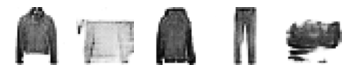

[4 8 4 1 8]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3342 - d_acc: 0.5909 - g_loss: 0.7534 - g_acc: 0.3865
Epoch 23/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3301 - d_acc: 0.5944 - g_loss: 0.7655 - g_acc: 0.3798

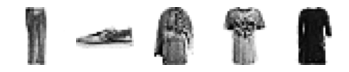

[1 7 4 0 3]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3301 - d_acc: 0.5944 - g_loss: 0.7655 - g_acc: 0.3798
Epoch 24/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3356 - d_acc: 0.5899 - g_loss: 0.7520 - g_acc: 0.3888

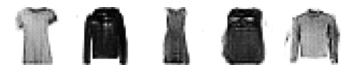

[6 4 3 2 6]
469/469 [==============================] - 12s 25ms/step - d_loss: 1.3356 - d_acc: 0.5899 - g_loss: 0.7520 - g_acc: 0.3888
Epoch 25/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3321 - d_acc: 0.5918 - g_loss: 0.7564 - g_acc: 0.3890

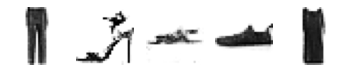

[1 5 5 7 3]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3321 - d_acc: 0.5918 - g_loss: 0.7564 - g_acc: 0.3891
Epoch 26/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3347 - d_acc: 0.5881 - g_loss: 0.7622 - g_acc: 0.3918

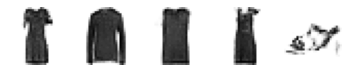

[3 2 0 3 5]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3347 - d_acc: 0.5881 - g_loss: 0.7621 - g_acc: 0.3918
Epoch 27/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3385 - d_acc: 0.5867 - g_loss: 0.7436 - g_acc: 0.3939

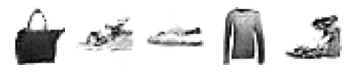

[8 5 5 2 5]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3385 - d_acc: 0.5867 - g_loss: 0.7436 - g_acc: 0.3939
Epoch 28/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3344 - d_acc: 0.5911 - g_loss: 0.7658 - g_acc: 0.3859

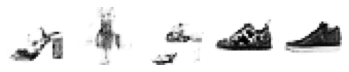

[5 3 5 7 7]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3344 - d_acc: 0.5911 - g_loss: 0.7658 - g_acc: 0.3859
Epoch 29/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3352 - d_acc: 0.5879 - g_loss: 0.7487 - g_acc: 0.3902

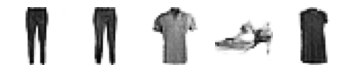

[1 1 0 5 6]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3352 - d_acc: 0.5879 - g_loss: 0.7488 - g_acc: 0.3902
Epoch 30/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3360 - d_acc: 0.5894 - g_loss: 0.7613 - g_acc: 0.3898

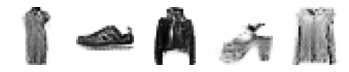

[3 7 4 5 6]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3360 - d_acc: 0.5894 - g_loss: 0.7614 - g_acc: 0.3897
Epoch 31/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3340 - d_acc: 0.5872 - g_loss: 0.7517 - g_acc: 0.3922

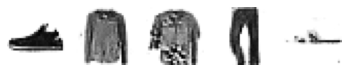

[7 6 6 1 5]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3340 - d_acc: 0.5872 - g_loss: 0.7517 - g_acc: 0.3922
Epoch 32/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3365 - d_acc: 0.5846 - g_loss: 0.7541 - g_acc: 0.3943

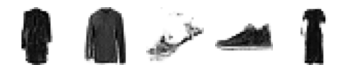

[4 2 5 7 3]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3365 - d_acc: 0.5846 - g_loss: 0.7542 - g_acc: 0.3943
Epoch 33/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3372 - d_acc: 0.5851 - g_loss: 0.7521 - g_acc: 0.3903

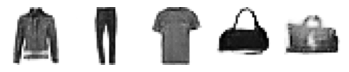

[4 1 0 8 8]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3372 - d_acc: 0.5851 - g_loss: 0.7521 - g_acc: 0.3903
Epoch 34/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3361 - d_acc: 0.5903 - g_loss: 0.7528 - g_acc: 0.3900

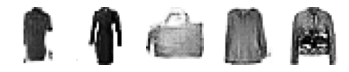

[0 3 8 6 4]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3361 - d_acc: 0.5903 - g_loss: 0.7528 - g_acc: 0.3900
Epoch 35/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3332 - d_acc: 0.5918 - g_loss: 0.7541 - g_acc: 0.3826

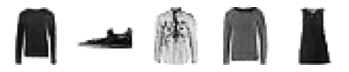

[2 7 6 2 0]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3332 - d_acc: 0.5918 - g_loss: 0.7541 - g_acc: 0.3826
Epoch 36/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3366 - d_acc: 0.5886 - g_loss: 0.7617 - g_acc: 0.3901

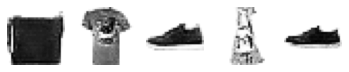

[8 0 7 3 7]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3366 - d_acc: 0.5886 - g_loss: 0.7617 - g_acc: 0.3901
Epoch 37/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3391 - d_acc: 0.5840 - g_loss: 0.7481 - g_acc: 0.3952

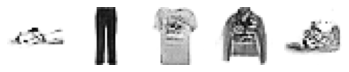

[5 1 0 4 7]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3391 - d_acc: 0.5840 - g_loss: 0.7481 - g_acc: 0.3952
Epoch 38/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3341 - d_acc: 0.5894 - g_loss: 0.7532 - g_acc: 0.3925

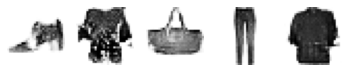

[5 6 8 1 6]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3341 - d_acc: 0.5894 - g_loss: 0.7533 - g_acc: 0.3924
Epoch 39/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3331 - d_acc: 0.5914 - g_loss: 0.7609 - g_acc: 0.3872

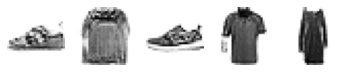

[5 2 7 6 3]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3331 - d_acc: 0.5914 - g_loss: 0.7609 - g_acc: 0.3872
Epoch 40/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3381 - d_acc: 0.5846 - g_loss: 0.7480 - g_acc: 0.3949

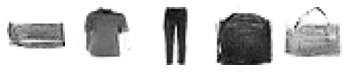

[8 0 1 8 8]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3380 - d_acc: 0.5847 - g_loss: 0.7480 - g_acc: 0.3949
Epoch 41/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3360 - d_acc: 0.5834 - g_loss: 0.7525 - g_acc: 0.3919

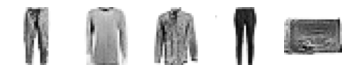

[1 2 6 1 8]
469/469 [==============================] - 13s 28ms/step - d_loss: 1.3360 - d_acc: 0.5834 - g_loss: 0.7525 - g_acc: 0.3919
Epoch 42/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3352 - d_acc: 0.5842 - g_loss: 0.7556 - g_acc: 0.3969

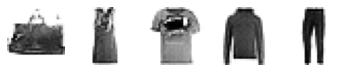

[8 0 0 2 1]
469/469 [==============================] - 14s 29ms/step - d_loss: 1.3352 - d_acc: 0.5841 - g_loss: 0.7556 - g_acc: 0.3969
Epoch 43/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3372 - d_acc: 0.5837 - g_loss: 0.7548 - g_acc: 0.3955

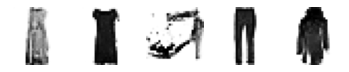

[3 3 5 1 4]
469/469 [==============================] - 13s 28ms/step - d_loss: 1.3372 - d_acc: 0.5837 - g_loss: 0.7548 - g_acc: 0.3955
Epoch 44/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3379 - d_acc: 0.5836 - g_loss: 0.7506 - g_acc: 0.3963

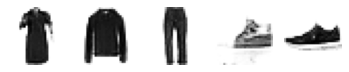

[3 2 1 7 7]
469/469 [==============================] - 12s 26ms/step - d_loss: 1.3379 - d_acc: 0.5836 - g_loss: 0.7506 - g_acc: 0.3963
Epoch 45/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3388 - d_acc: 0.5832 - g_loss: 0.7625 - g_acc: 0.3939

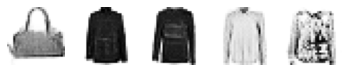

[8 4 2 6 6]
469/469 [==============================] - 12s 27ms/step - d_loss: 1.3388 - d_acc: 0.5832 - g_loss: 0.7624 - g_acc: 0.3939
Epoch 46/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3389 - d_acc: 0.5831 - g_loss: 0.7583 - g_acc: 0.3985

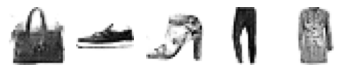

[8 7 5 1 3]
469/469 [==============================] - 12s 27ms/step - d_loss: 1.3389 - d_acc: 0.5831 - g_loss: 0.7583 - g_acc: 0.3985
Epoch 47/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3391 - d_acc: 0.5835 - g_loss: 0.7517 - g_acc: 0.3961

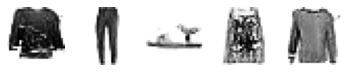

[6 1 5 6 6]
469/469 [==============================] - 13s 27ms/step - d_loss: 1.3392 - d_acc: 0.5835 - g_loss: 0.7517 - g_acc: 0.3962
Epoch 48/50
467/469 [============================>.] - ETA: 0s - d_loss: 1.3368 - d_acc: 0.5865 - g_loss: 0.7584 - g_acc: 0.3931

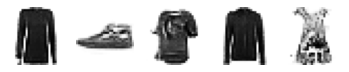

[2 7 0 4 3]
469/469 [==============================] - 13s 27ms/step - d_loss: 1.3368 - d_acc: 0.5865 - g_loss: 0.7584 - g_acc: 0.3931
Epoch 49/50
468/469 [============================>.] - ETA: 0s - d_loss: 1.3360 - d_acc: 0.5862 - g_loss: 0.7523 - g_acc: 0.3928

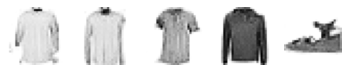

[6 6 6 4 5]
469/469 [==============================] - 14s 30ms/step - d_loss: 1.3360 - d_acc: 0.5862 - g_loss: 0.7523 - g_acc: 0.3928
Epoch 50/50
469/469 [==============================] - ETA: 0s - d_loss: 1.3344 - d_acc: 0.5857 - g_loss: 0.7596 - g_acc: 0.3926

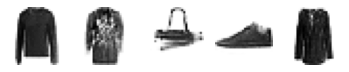

[2 4 8 7 6]
469/469 [==============================] - 13s 29ms/step - d_loss: 1.3344 - d_acc: 0.5857 - g_loss: 0.7596 - g_acc: 0.3926


In [58]:
gen.fit([x_train.reshape(-1, 28, 28, 1), y_train.reshape(-1, 1)], 
         epochs=50, batch_size=128, callbacks=[Monitor()])

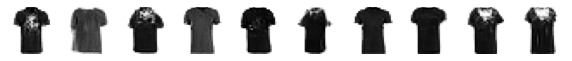

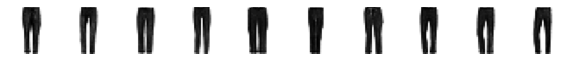

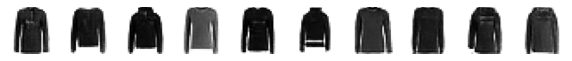

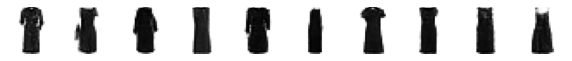

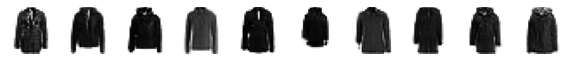

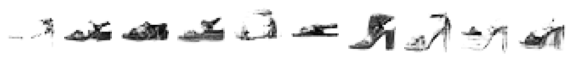

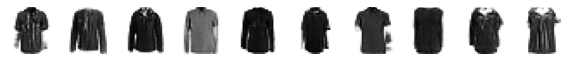

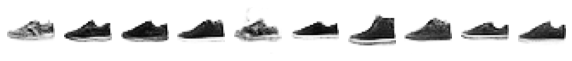

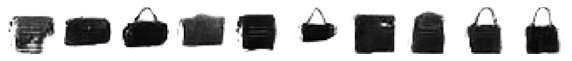

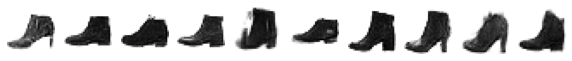

In [60]:
import numpy as np
x_test = np.random.randn(10 * 100).reshape(10, 100)

for j in range(10):
    images = generator.predict([x_test, np.full(10, j)])
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis("off")
        plt.imshow(images[i, :, :, 0], cmap="gray_r")
    plt.show()